
# Table of contents
1. Introduction: Business Problem
2. Data Requirements
3. Methodology
4. Analysis
5. Results
6. Discussion
7. Conclusion
## Introduction: Business Problem 
This project deals with discussing the neighborhoods of Chennai, The Detroit of India. This project would specifically help Business people planning to start Restaurants, Hotels, etc. in Chennai, Tamil Nadu, India.

The Foursquare API is used to access the venues in the neighborhoods. Since, it returns less venues in the neighborhoods, we would be analysing areas for which countable number of venues are obtained. Then they are clustered based on their venues using Data Science Techniques. Here the k-means clustering algorithm is used to achieve the task. The optimal number of clusters can be obtained using silhouette score. Folium visualization library can be used to visualize the clusters superimposed on the map of Chennai city. These clusters can be analyzed to help small scale business owners select a suitable location for their need such as Hotels, Shopping Malls, Restaurants or even specifically Indian restaurants or Coffee shops.

In [1]:
import re
import json
import requests
import numpy as np
from bs4 import BeautifulSoup

import pandas as pd
#display all rows
pd.set_option('display.max_rows', None)
#display all columns
pd.set_option('display.max_columns', None)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from geopy.geocoders import Nominatim

!pip install folium
import folium # map rendering library

!pip install matplotlib
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

print('Libraries imported.')

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 94 kB 5.6 MB/s  eta 0:00:01
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Libraries imported.


## Data Requirements 
Chennai has multiple neighborhoods. Lets use the following dataset which has the list of locations in chennai along with their Latitude and Longitude:

https://chennaiiq.com/chennai/latitude_longitude_areas.asp

But the Latitude and Longitude data provided here is in Degrees Minute Seconds format. Thus before starting the analysis, the location data has to be converted to Decimal Degrees. First,. lets access the html file.

In [2]:
url = 'https://chennaiiq.com/chennai/latitude_longitude_areas.asp'

html = requests.get(url)
print(html)

<Response [200]>


A Reponse value of 200 means that the process was successful. Now we need to clean the file to access the Neighborhoods and their Locations. Lets use BeautifulSoup library to parse the html file in order to make it easier to access.

In [3]:
soup = BeautifulSoup(html.text, 'html.parser')
table = soup.find("table", attrs={"class": "TBox"})


The html has been parsed and it can be used to build the dataset. Let us access the Location data and store it in a pandas dataframe, chennai_data.

### Data Collection:

In [4]:
table_data = []
index = ['S.No.', 'Location', 'Latitude', 'Longitude']
for tr in table.find_all("tr", attrs={"class": "tab"}):
    t_row = {}
    for td, th in zip(tr.find_all("td"), index): 
        t_row[th] = td.text.replace('\n', '').strip()
    table_data.append(t_row)

chennai_data = pd.DataFrame(table_data[:-1], columns=index)
chennai_data.drop(columns=['S.No.'], inplace=True)
chennai_data.at[0,'Location'] = 'Adyar Bus Debot'
chennai_data.rename(columns={'Location': 'Neighborhood'}, inplace=True)
print(chennai_data.shape)
chennai_data.head()

(105, 3)


,Neighborhood,Latitude,Longitude
0,Adyar Bus Debot,"12°59'50"" N","80°15'25"" E"
1,Adyar Signal,"13°00'23"" N","80°15'27"" E"
2,Alandur,"13°00'28"" N","80°12'35"" E"
3,Ambattur,"13°06'36"" N","80°10'12"" E"
4,Anna Arch,"13°04'28"" N","80°13'06"" E"



#### Convert Degrees Minute Seconds to Decimal Degrees
There are a total of 105 neighborhoods. But as said earlier the Latitude and Longitude data needs to be converted Degrees Minute Seconds to Decimal Degrees. The dms2dd fucntion defined below will solve this problem.

In [5]:
def dms2dd(s):
    degrees, minutes, seconds, direction = re.split('[°\'"]+', s)
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    if direction in ('S','W'):
        dd*= -1
    return dd

chennai_data['Latitude'] = chennai_data['Latitude'].apply(dms2dd)
chennai_data['Longitude'] = chennai_data['Longitude'].apply(dms2dd)
print(chennai_data.shape)
chennai_data.head()

(105, 3)


,Neighborhood,Latitude,Longitude
0,Adyar Bus Debot,12.997222,80.256944
1,Adyar Signal,13.006389,80.257500
2,Alandur,13.007778,80.209722
3,Ambattur,13.110000,80.170000
4,Anna Arch,13.074444,80.218333


In [6]:
address = 'Chennai, Tamil Nadu'

geolocator = Nominatim(user_agent="chennai_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of chennai are {}, {}.'.format(latitude, longitude))

The geographical coordinate of chennai are 13.0836939, 80.270186.


In [7]:
# create map of Toronto using latitude and longitude values
chennai_map = folium.Map(location=[latitude, longitude], zoom_start=11)    
chennai_map


## Chennai Map with the neighborhoods superimposed on top:

In [8]:
# add neighborhood markers to map
for lat, lng, location in zip(chennai_data['Latitude'], chennai_data['Longitude'], chennai_data['Neighborhood']):
    label = '{}'.format(location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(chennai_map)  

chennai_map

#### Define Foursquare Credentials and Version

In [9]:
CLIENT_ID = 'SAEBCCYP1NT0DDB3XVZMMRAJLYIXL0P14KTREPC4DY0VTL2S' # your Foursquare ID
CLIENT_SECRET = 'IPQP43WMLF3FTHMOW2JJY2PZKLC3MZMBW0JM4FP0QXMIJTTO' # your Foursquare Secret
VERSION = '20210515' # Foursquare API version


### Explore neighborhoods in Chennai
The following function will send a explore request for each neighborhood and return the 100 most popular places in the neighborhood around 500 meters.

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        count = 1
        while count != 5:
            try:
                results = requests.get(url).json()["response"]['groups'][0]['items']
                count = 5
            except:
                count += 1
    
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
chennai_venues = getNearbyVenues(names = chennai_data['Neighborhood'],
                                 latitudes = chennai_data['Latitude'],
                                 longitudes = chennai_data['Longitude']
                                 )

print(chennai_venues.shape)
chennai_venues.head()

(1174, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adyar Bus Debot,12.997222,80.256944,Zaitoon Restaurant,12.996861,80.256178,Middle Eastern Restaurant
1,Adyar Bus Debot,12.997222,80.256944,Kuttanadu Restaurant,12.997010,80.257799,Asian Restaurant
2,Adyar Bus Debot,12.997222,80.256944,Zha Cafe,12.999730,80.254806,Café
3,Adyar Bus Debot,12.997222,80.256944,Kovai Pazhamudir Nilayam,12.996522,80.259776,Fruit & Vegetable Store
4,Adyar Bus Debot,12.997222,80.256944,"Adyar Ananda Bhavan, Besant Nagar",12.996678,80.258275,Fast Food Restaurant


A total of 1174 venues were obtained. Now lets check the number of venues returned per neighborhood.

In [12]:
chennai_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
AVM Studio,5,5,5,5,5,5
Adyar Bus Debot,19,19,19,19,19,19
Adyar Signal,30,30,30,30,30,30
Alandur,11,11,11,11,11,11
Ambattur,2,2,2,2,2,2
Anna Arch,14,14,14,14,14,14
Anna Nagar Roundana,20,20,20,20,20,20
Anna Nagar West Terminus,9,9,9,9,9,9
Anna Statue,14,14,14,14,14,14



From the above dataframe we can see that Taj Coromandal returned the highest number of venues i.e. 49. Now lets check the unique categories of all the venues returned.

In [13]:

print('There are {} uniques categories.'.format(len(chennai_venues['Venue Category'].unique())))

There are 149 uniques categories.



# Methodology 
Now, we have the neighborhoods data of chennai (105 neighborhoods). We also have the most popular venues in each neighborhood obtained using Foursquare API. A total of 1174 venues have been obtained in the whole city and 149 unique categories. But as seen we have multiple neighborhoods with less than 10 venues returned. In order to create a good analysis let's consider only the neighborhoods with more than 10 venues.

We can perform one hot encoding on the obtained data set and use it find the 10 most common venue category in each neighborhood. Then clustering can be performed on the dataset. Here K - Nearest Neighbor clustering technique have been used. To find the optimal number of clusters silhouette score metric technique is used.

The clusters obtained can be analyzed to find the major type of venue categories in each cluster. This data can be used to suggest business people, suitable locations based on the category.

# Analysis 
First, lets visualize the number of venues obtained in all the neighborhoods of Chennai.

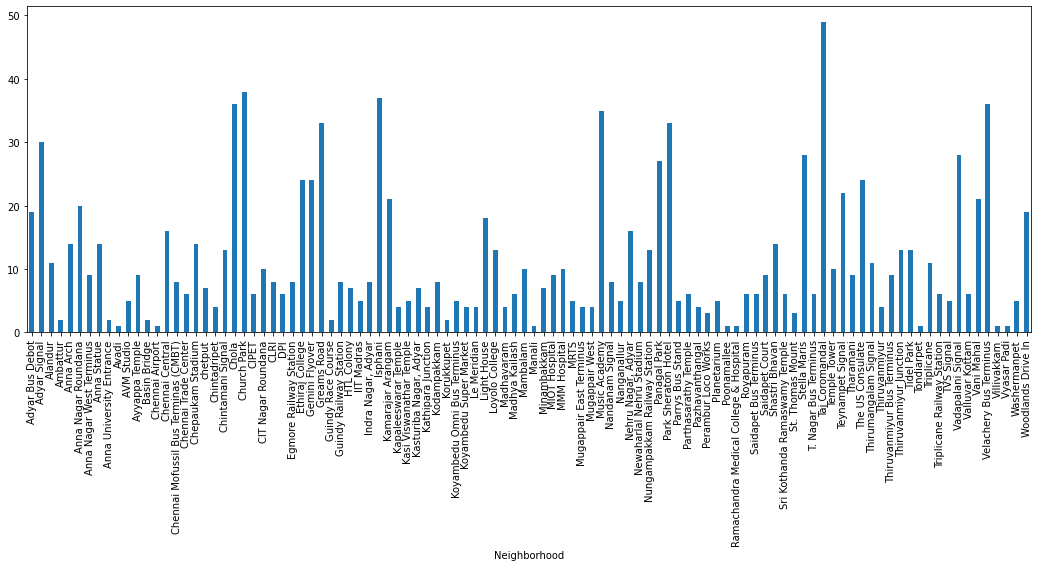

In [14]:
df = chennai_venues.groupby(['Neighborhood'], sort=False)['Venue'].count()
df.plot.bar(figsize=(18,6))


As we can see from the above bar chart, there are many neighborhoods with less than 10 venues which can be remove before performing the analysis to obtain better results. The following plot shows only the neighborhoods from which 10 or more than 10 venues were obtained.

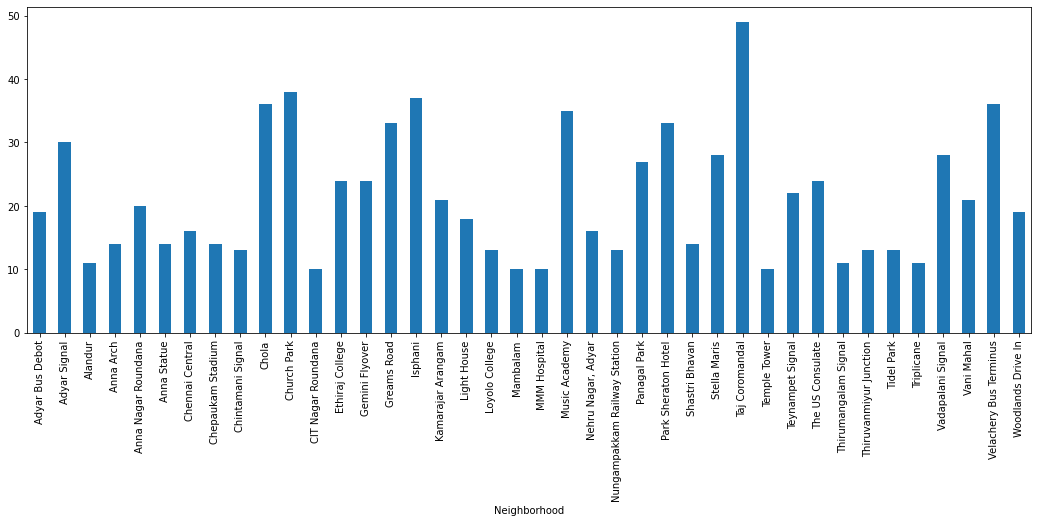

In [15]:
df = df[df >= 10]
df.plot.bar(figsize=(18,6))

Lets create a new dataframe, chennai_venues_top that contains only the neighborhoods with 10+ venues and the venues with their details included.

In [16]:
chennai_venues_top = chennai_venues[chennai_venues['Neighborhood'].isin(df.index.tolist())]
chennai_venues_top.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adyar Bus Debot,12.997222,80.256944,Zaitoon Restaurant,12.996861,80.256178,Middle Eastern Restaurant
1,Adyar Bus Debot,12.997222,80.256944,Kuttanadu Restaurant,12.997010,80.257799,Asian Restaurant
2,Adyar Bus Debot,12.997222,80.256944,Zha Cafe,12.999730,80.254806,Café
3,Adyar Bus Debot,12.997222,80.256944,Kovai Pazhamudir Nilayam,12.996522,80.259776,Fruit & Vegetable Store
4,Adyar Bus Debot,12.997222,80.256944,"Adyar Ananda Bhavan, Besant Nagar",12.996678,80.258275,Fast Food Restaurant


In [17]:
chennai_onehot = pd.get_dummies(chennai_venues_top['Venue Category'], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
chennai_onehot['Neighborhood'] = chennai_venues_top['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = chennai_onehot.columns.tolist()
fixed_columns.insert(0, fixed_columns.pop(fixed_columns.index('Neighborhood')))
chennai_onehot = chennai_onehot.reindex(columns = fixed_columns)

print(chennai_onehot.shape)
chennai_onehot.head()

(848, 120)


,Neighborhood,Accessories Store,African Restaurant,Airport,American Restaurant,Amphitheater,Andhra Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Beach,Bengali Restaurant,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Buffet,Bus Station,Café,Chettinad Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Department Store,Dessert Shop,Dhaba,Diner,Donut Shop,Electronics Store,Fast Food Restaurant,Flea Market,Food Court,Fried Chicken Joint,Fruit & Vegetable Store,Gaming Cafe,Garden,General Entertainment,Gourmet Shop,Grocery Store,Gym,Health Food Store,Hookah Bar,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indian Sweet Shop,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kerala Restaurant,Korean Restaurant,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Multicuisine Indian Restaurant,Multiplex,Music Store,Music Venue,Nightclub,North Indian Restaurant,Office,Paper / Office Supplies Store,Park,Pizza Place,Platform,Playground,Pool,Print Shop,Pub,Ramen Restaurant,Recreation Center,Restaurant,Rock Club,Russian Restaurant,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Shoe Store,Shopping Mall,Snack Place,South Indian Restaurant,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Train,Train Station,Vegetarian / Vegan Restaurant,Women's Store
0,Adyar Bus Debot,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Adyar Bus Debot,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Adyar Bus Debot,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Adyar Bus Debot,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Adyar Bus Debot,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
chennai_grouped = chennai_onehot.groupby('Neighborhood').mean().reset_index()
print(chennai_grouped.shape)
chennai_grouped.head()

(40, 120)


,Neighborhood,Accessories Store,African Restaurant,Airport,American Restaurant,Amphitheater,Andhra Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Beach,Bengali Restaurant,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Buffet,Bus Station,Café,Chettinad Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Department Store,Dessert Shop,Dhaba,Diner,Donut Shop,Electronics Store,Fast Food Restaurant,Flea Market,Food Court,Fried Chicken Joint,Fruit & Vegetable Store,Gaming Cafe,Garden,General Entertainment,Gourmet Shop,Grocery Store,Gym,Health Food Store,Hookah Bar,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indian Sweet Shop,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kerala Restaurant,Korean Restaurant,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Multicuisine Indian Restaurant,Multiplex,Music Store,Music Venue,Nightclub,North Indian Restaurant,Office,Paper / Office Supplies Store,Park,Pizza Place,Platform,Playground,Pool,Print Shop,Pub,Ramen Restaurant,Recreation Center,Restaurant,Rock Club,Russian Restaurant,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Shoe Store,Shopping Mall,Snack Place,South Indian Restaurant,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Train,Train Station,Vegetarian / Vegan Restaurant,Women's Store
0,Adyar Bus Debot,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.105263,0.0,0.052632,0.052632,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.052632,0.0,0.000000,0.052632,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.052632,0.000000,0.0,0.0,0.0,0.000000,0.105263,0.0,0.0,0.052632,0.052632,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00,0.000000,0.210526,0.0,0.000000,0.0,0.0,0.052632,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.052632,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.052632,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
1,Adyar Signal,0.0,0.0,0.000000,0.0,0.0,0.0,0.033333,0.0,0.0,0.033333,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.033333,0.0,0.0,0.000000,0.0,0.000000,0.033333,0.0,0.0,0.0,0.000000,0.0,0.066667,0.0,0.0,0.0,0.0,0.000000,0.033333,0.0,0.0,0.0,0.066667,0.033333,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.000000,0.00,0.033333,0.300000,0.0,0.033333,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.033333,0.0,0.000000,0.0,0.0,0.0,0.066667,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.033333,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.033333,0.0
2,Alandur,0.0,0.0,0.090909,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.090909,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.181818,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.090909,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.181818,0.00,0.000000,0.090909,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.090909,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.090909,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,0.000000,0.0
3,Anna Arch,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.071429,0.0,0.000000,0.0,0.0,0.0,0.071429,0.0,0.0,0.000000,0.0,0.000000,0.071429,0.0,0.0,0.0,0.142857,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0

The following function returns the top_venues of each neighborhood

In [19]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Lets use the above function to obtaine the 10 most common venues in each neighborhood and store in the new pandas dataframe neighborhoods_venues_sorted.

In [20]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create column names according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = chennai_grouped['Neighborhood']

for ind in np.arange(chennai_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chennai_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adyar Bus Debot,Indian Restaurant,Fast Food Restaurant,Asian Restaurant,Bakery,Juice Bar,Fruit & Vegetable Store,Fried Chicken Joint,Middle Eastern Restaurant,Department Store,Café
1,Adyar Signal,Indian Restaurant,North Indian Restaurant,Coffee Shop,Electronics Store,Snack Place,Dessert Shop,Movie Theater,Café,Fast Food Restaurant,Rock Club
2,Alandur,Hotel,Bus Station,Metro Station,Bar,Train,Airport,Indian Restaurant,Electronics Store,South Indian Restaurant,Diner
3,Anna Arch,Clothing Store,Electronics Store,Fast Food Restaurant,Sporting Goods Shop,Multiplex,Café,Bookstore,Scenic Lookout,Shopping Mall,Bakery
4,Anna Nagar Roundana,Indian Restaurant,Chinese Restaurant,Fast Food Restaurant,Electronics Store,Bakery,South Indian Restaurant,Bookstore,Asian Restaurant,Clothing Store,Juice Bar



### Cluster Neighborhoods
Here k-Nearest Neighborhoods clustering technique is used. Lets use the silhouette_score to obtain the best value for the number of clusters.

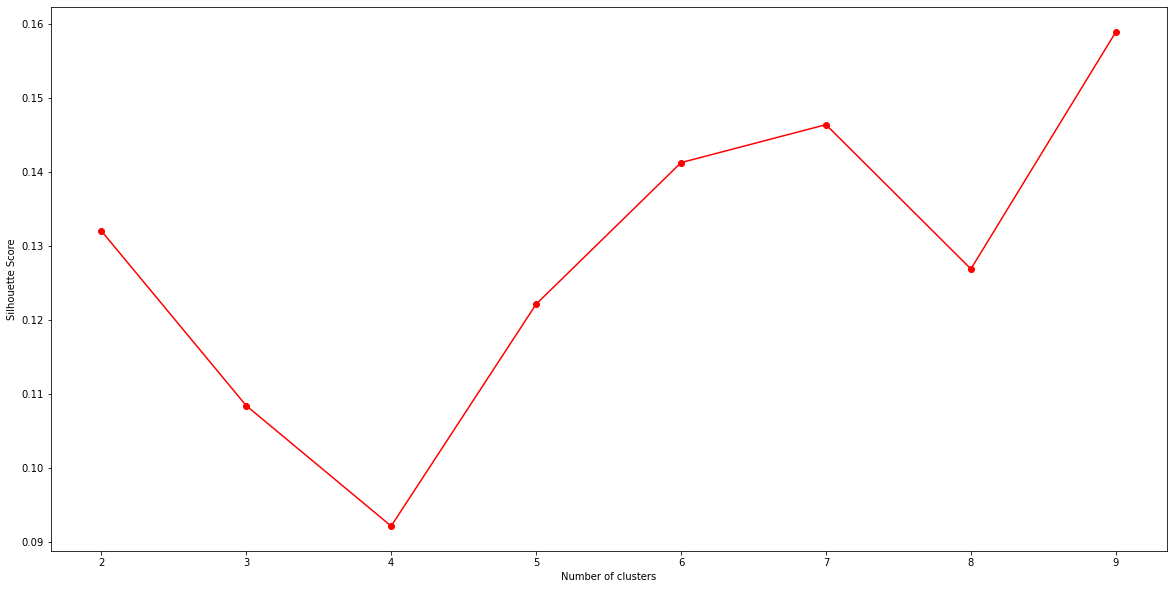

In [21]:

chennai_grouped_clustering = chennai_grouped.drop('Neighborhood', 1)

max_score = 10
scores = []

for kclusters in range(2, max_score):
    # Run k-means clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(chennai_grouped_clustering)
    
    # Gets the silhouette score
    score = silhouette_score(chennai_grouped_clustering, kmeans)
    scores.append(score)

plt.figure(figsize=(20,10))
plt.plot(np.arange(2, max_score), scores, 'ro-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.xticks(np.arange(2, max_score))
plt.show()

In [22]:
# select best number of clusters
kclusters = 9

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chennai_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 1, 8, 2, 0, 5, 1, 2, 2], dtype=int32)

Add the cluster labels to the neighborhoods_venues_sorted dataframe. And lets create a new datframe chennai_merged which has the neighborhood details, cluster labels and the 10 most common venues in that neighborhood.

In [23]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

chennai_merged = chennai_venues_top[chennai_venues_top.columns[0:3]].drop_duplicates()
chennai_merged.reset_index(drop = True, inplace = True)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
chennai_merged = chennai_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

chennai_merged.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adyar Bus Debot,12.997222,80.256944,2,Indian Restaurant,Fast Food Restaurant,Asian Restaurant,Bakery,Juice Bar,Fruit & Vegetable Store,Fried Chicken Joint,Middle Eastern Restaurant,Department Store,Café
1,Adyar Signal,13.006389,80.257500,2,Indian Restaurant,North Indian Restaurant,Coffee Shop,Electronics Store,Snack Place,Dessert Shop,Movie Theater,Café,Fast Food Restaurant,Rock Club
2,Alandur,13.007778,80.209722,1,Hotel,Bus Station,Metro Station,Bar,Train,Airport,Indian Restaurant,Electronics Store,South Indian Restaurant,Diner
3,Anna Arch,13.074444,80.218333,8,Clothing Store,Electronics Store,Fast Food Restaurant,Sporting Goods Shop,Multiplex,Café,Bookstore,Scenic Lookout,Shopping Mall,Bakery
4,Anna Nagar Roundana,13.084444,80.218056,2,Indian Restaurant,Chinese Restaurant,Fast Food Restaurant,Electronics Store,Bakery,South Indian Restaurant,Bookstore,Asian Restaurant,Clothing Store,Juice Bar



## Results 
Let’s examine the clusters and find the discriminating venue categories that distinguish each cluster. For this purpose lets also print the ten most common venue category in each cluster.

### Cluster 1

In [24]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 0, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Anna Statue,Indian Restaurant,Multiplex,Electronics Store,Flea Market,Dessert Shop,General Entertainment,Movie Theater,Fast Food Restaurant,Comfort Food Restaurant,Concert Hall
35,Triplicane,Indian Restaurant,Multiplex,Dessert Shop,General Entertainment,Electronics Store,Flea Market,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop


In [25]:

cluster1 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 0, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues1 = (cluster1['1st Most Common Venue'].append(
    cluster1['2nd Most Common Venue']).append(
    cluster1['3rd Most Common Venue']).append(
    cluster1['4th Most Common Venue']).append(
    cluster1['5th Most Common Venue']).append(
    cluster1['6th Most Common Venue']).append(
    cluster1['7th Most Common Venue']).append(
    cluster1['8th Most Common Venue']).append(
    cluster1['9th Most Common Venue']).append(
    cluster1['10th Most Common Venue']))

print(venues1.value_counts().head(10))

Dessert Shop               2
Concert Hall               2
Electronics Store          2
General Entertainment      2
Indian Restaurant          2
Multiplex                  2
Comfort Food Restaurant    2
Flea Market                2
Convenience Store          1
Cosmetics Shop             1
dtype: int64


### Cluster 2

In [26]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 1, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Alandur,Hotel,Bus Station,Metro Station,Bar,Train,Airport,Indian Restaurant,Electronics Store,South Indian Restaurant,Diner
6,Chennai Central,Train Station,Indian Restaurant,Bookstore,Hotel,Fast Food Restaurant,Nightclub,Platform,Bus Station,Sandwich Place,Metro Station
9,Chola,Indian Restaurant,Hotel,Ice Cream Shop,Concert Hall,Restaurant,Mexican Restaurant,Café,Chinese Restaurant,Comfort Food Restaurant,Dessert Shop
12,Ethiraj College,Hotel,Kebab Restaurant,Indian Restaurant,Café,Pizza Place,Juice Bar,Fast Food Restaurant,Middle Eastern Restaurant,Donut Shop,Chettinad Restaurant
13,Gemini Flyover,Indian Restaurant,Sandwich Place,Hotel,Nightclub,Coffee Shop,Thai Restaurant,Bar,Chinese Restaurant,Pizza Place,Department Store
15,Isphani,Indian Restaurant,Hotel,Chinese Restaurant,Coffee Shop,Nightclub,Café,Pizza Place,Lounge,Sandwich Place,South Indian Restaurant
16,Kamarajar Arangam,Indian Restaurant,Hotel,Café,Lounge,Nightclub,Pizza Place,BBQ Joint,Coffee Shop,Park,Bistro
21,Music Academy,Indian Restaurant,Hotel,Café,Concert Hall,Restaurant,Women's Store,Grocery Store,Mexican Restaurant,Lounge,Juice Bar
25,Park Sheraton Hotel,Hotel,Café,Italian Restaurant,Restaurant,Indian Restaurant,Japanese Restaurant,Coffee Shop,Nightclub,Chinese Restaurant,Thai Restaurant
27,Stella Maris,Indian Restaurant,Hotel,Women's Store,Sandwich Place,Restaurant,Mexican Restaurant,Kerala Restaurant,Juice Bar,Ice Cream Shop,Garden


In [27]:
cluster2 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 1, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues2 = (cluster2['1st Most Common Venue'].append(
    cluster2['2nd Most Common Venue']).append(
    cluster2['3rd Most Common Venue']).append(
    cluster2['4th Most Common Venue']).append(
    cluster2['5th Most Common Venue']).append(
    cluster2['6th Most Common Venue']).append(
    cluster2['7th Most Common Venue']).append(
    cluster2['8th Most Common Venue']).append(
    cluster2['9th Most Common Venue']).append(
    cluster2['10th Most Common Venue']))

print(venues2.value_counts().head(10))

Indian Restaurant     15
Hotel                 14
Café                   8
Nightclub              7
Chinese Restaurant     7
Sandwich Place         6
Coffee Shop            6
Pizza Place            5
Lounge                 5
Department Store       4
dtype: int64



### Cluster 3

In [31]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 2, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adyar Bus Debot,Indian Restaurant,Fast Food Restaurant,Asian Restaurant,Bakery,Juice Bar,Fruit & Vegetable Store,Fried Chicken Joint,Middle Eastern Restaurant,Department Store,Café
1,Adyar Signal,Indian Restaurant,North Indian Restaurant,Coffee Shop,Electronics Store,Snack Place,Dessert Shop,Movie Theater,Café,Fast Food Restaurant,Rock Club
4,Anna Nagar Roundana,Indian Restaurant,Chinese Restaurant,Fast Food Restaurant,Electronics Store,Bakery,South Indian Restaurant,Bookstore,Asian Restaurant,Clothing Store,Juice Bar
7,Chepaukam Stadium,Indian Restaurant,General Entertainment,Café,Electronics Store,Bar,Breakfast Spot,Mediterranean Restaurant,Multiplex,Bookstore,Hotel
8,Chintamani Signal,Indian Restaurant,Restaurant,Multicuisine Indian Restaurant,Coffee Shop,Electronics Store,Snack Place,Bakery,Middle Eastern Restaurant,Ice Cream Shop,Dessert Shop
26,Shastri Bhavan,Indian Restaurant,Chinese Restaurant,Coffee Shop,Japanese Restaurant,Theater,Hotel,Convenience Store,Multicuisine Indian Restaurant,Asian Restaurant,Dhaba
38,Velachery Bus Terminus,Indian Restaurant,Fast Food Restaurant,Clothing Store,Chinese Restaurant,Restaurant,Kerala Restaurant,Liquor Store,Juice Bar,Bar,Department Store


In [32]:
cluster3 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 2, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues3 = (cluster3['1st Most Common Venue'].append(
    cluster3['2nd Most Common Venue']).append(
    cluster3['3rd Most Common Venue']).append(
    cluster3['4th Most Common Venue']).append(
    cluster3['5th Most Common Venue']).append(
    cluster3['6th Most Common Venue']).append(
    cluster3['7th Most Common Venue']).append(
    cluster3['8th Most Common Venue']).append(
    cluster3['9th Most Common Venue']).append(
    cluster3['10th Most Common Venue']))

print(venues3.value_counts().head(10))

Indian Restaurant                 7
Electronics Store                 4
Fast Food Restaurant              4
Chinese Restaurant                3
Café                              3
Bakery                            3
Coffee Shop                       3
Juice Bar                         3
Asian Restaurant                  3
Multicuisine Indian Restaurant    2
dtype: int64


### Cluster 4

In [33]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 3, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Mambalam,Clothing Store,Asian Restaurant,Boutique,South Indian Restaurant,Miscellaneous Shop,Jewelry Store,Indian Restaurant,Cosmetics Shop,Department Store,Dessert Shop
24,Panagal Park,Clothing Store,Indian Restaurant,Jewelry Store,Women's Store,Snack Place,Vegetarian / Vegan Restaurant,Miscellaneous Shop,Dessert Shop,Coffee Shop,Pizza Place


In [34]:

cluster4 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 3, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues4 = (cluster4['1st Most Common Venue'].append(
    cluster4['2nd Most Common Venue']).append(
    cluster4['3rd Most Common Venue']).append(
    cluster4['4th Most Common Venue']).append(
    cluster4['5th Most Common Venue']).append(
    cluster4['6th Most Common Venue']).append(
    cluster4['7th Most Common Venue']).append(
    cluster4['8th Most Common Venue']).append(
    cluster4['9th Most Common Venue']).append(
    cluster4['10th Most Common Venue']))

print(venues4.value_counts().head(10))

Indian Restaurant     2
Clothing Store        2
Dessert Shop          2
Jewelry Store         2
Miscellaneous Shop    2
Snack Place           1
Department Store      1
Cosmetics Shop        1
Women's Store         1
Coffee Shop           1
dtype: int64


### Cluster 5

In [35]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 4, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Church Park,Indian Restaurant,Multiplex,Bakery,Café,Movie Theater,Chinese Restaurant,Middle Eastern Restaurant,Pool,Park,Nightclub
14,Greams Road,Multiplex,Indian Restaurant,Café,Middle Eastern Restaurant,Movie Theater,Juice Bar,Bakery,Chinese Restaurant,Restaurant,Buffet
20,MMM Hospital,Department Store,Health Food Store,Fruit & Vegetable Store,Bakery,Convenience Store,Pizza Place,Juice Bar,Indian Restaurant,Middle Eastern Restaurant,Concert Hall
32,Thirumangalam Signal,Indian Restaurant,Pizza Place,Metro Station,Vegetarian / Vegan Restaurant,Mobile Phone Shop,Tennis Court,Jewelry Store,Print Shop,Café,Bus Station
33,Thiruvanmiyur Junction,Indian Restaurant,Bus Station,Indian Sweet Shop,Vegetarian / Vegan Restaurant,Hotel,Juice Bar,Gym,Multiplex,Hotel Bar,Clothing Store


In [36]:
cluster5 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 4, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues5 = (cluster5['1st Most Common Venue'].append(
    cluster5['2nd Most Common Venue']).append(
    cluster5['3rd Most Common Venue']).append(
    cluster5['4th Most Common Venue']).append(
    cluster5['5th Most Common Venue']).append(
    cluster5['6th Most Common Venue']).append(
    cluster5['7th Most Common Venue']).append(
    cluster5['8th Most Common Venue']).append(
    cluster5['9th Most Common Venue']).append(
    cluster5['10th Most Common Venue']))

print(venues5.value_counts().head(10))

Indian Restaurant                5
Café                             3
Juice Bar                        3
Bakery                           3
Middle Eastern Restaurant        3
Multiplex                        3
Bus Station                      2
Pizza Place                      2
Chinese Restaurant               2
Vegetarian / Vegan Restaurant    2
dtype: int64


### Cluster 6

In [38]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 5, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,CIT Nagar Roundana,Italian Restaurant,South Indian Restaurant,Hotel,Lounge,Department Store,Cocktail Bar,Pub,Bar,Ice Cream Shop,Art Gallery
29,Temple Tower,Bar,Art Gallery,Cocktail Bar,Lounge,South Indian Restaurant,Pub,Department Store,Sports Bar,Playground,Hotel


In [39]:
cluster6 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 5, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues6 = (cluster6['1st Most Common Venue'].append(
    cluster6['2nd Most Common Venue']).append(
    cluster6['3rd Most Common Venue']).append(
    cluster6['4th Most Common Venue']).append(
    cluster6['5th Most Common Venue']).append(
    cluster6['6th Most Common Venue']).append(
    cluster6['7th Most Common Venue']).append(
    cluster6['8th Most Common Venue']).append(
    cluster6['9th Most Common Venue']).append(
    cluster6['10th Most Common Venue']))

print(venues6.value_counts().head(10))

Cocktail Bar               2
Hotel                      2
Pub                        2
Lounge                     2
Bar                        2
South Indian Restaurant    2
Department Store           2
Art Gallery                2
Sports Bar                 1
Playground                 1
dtype: int64


### Cluster 7

In [40]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 6, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
34,Tidel Park,Food Court,Office,Sandwich Place,Platform,Café,Bus Station,Fast Food Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Grocery Store


In [41]:
cluster7 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 6, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues7 = (cluster7['1st Most Common Venue'].append(
    cluster7['2nd Most Common Venue']).append(
    cluster7['3rd Most Common Venue']).append(
    cluster7['4th Most Common Venue']).append(
    cluster7['5th Most Common Venue']).append(
    cluster7['6th Most Common Venue']).append(
    cluster7['7th Most Common Venue']).append(
    cluster7['8th Most Common Venue']).append(
    cluster7['9th Most Common Venue']).append(
    cluster7['10th Most Common Venue']))

print(venues7.value_counts().head(10))

Vegetarian / Vegan Restaurant    1
Food Court                       1
Office                           1
Fast Food Restaurant             1
Grocery Store                    1
Sandwich Place                   1
Bus Station                      1
Platform                         1
Indian Restaurant                1
Café                             1
dtype: int64


### Cluster 8

In [43]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 7, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,"Nehru Nagar, Adyar",Indian Restaurant,Café,Pizza Place,Women's Store,Sandwich Place,Juice Bar,Department Store,Chinese Restaurant,Ice Cream Shop,Arts & Crafts Store


In [44]:
cluster8 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 7, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues8 = (cluster8['1st Most Common Venue'].append(
    cluster8['2nd Most Common Venue']).append(
    cluster8['3rd Most Common Venue']).append(
    cluster8['4th Most Common Venue']).append(
    cluster8['5th Most Common Venue']).append(
    cluster8['6th Most Common Venue']).append(
    cluster8['7th Most Common Venue']).append(
    cluster8['8th Most Common Venue']).append(
    cluster8['9th Most Common Venue']).append(
    cluster8['10th Most Common Venue']))

print(venues8.value_counts().head(10))

Pizza Place            1
Chinese Restaurant     1
Indian Restaurant      1
Arts & Crafts Store    1
Department Store       1
Juice Bar              1
Women's Store          1
Ice Cream Shop         1
Sandwich Place         1
Café                   1
dtype: int64


## Discussion

Lets visulaize the top 5 most common venue categories in each of the cluster.

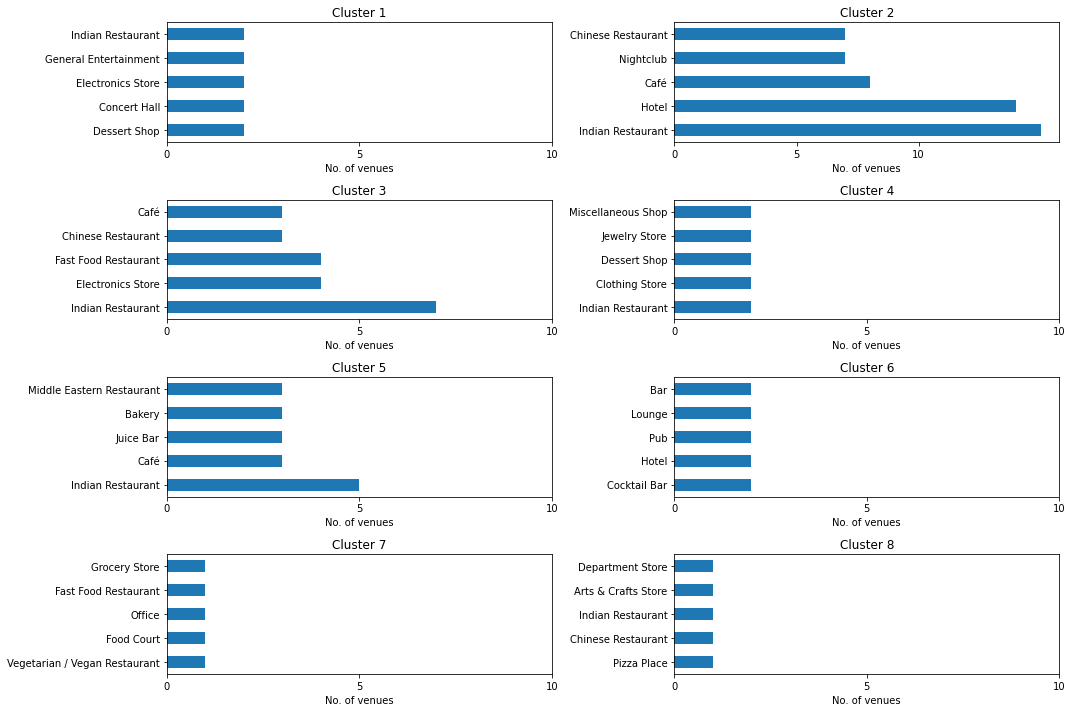

In [46]:
df_list = [venues1 ,venues2, venues3, venues4, venues5, venues6, venues7, venues8]
fig, axes = plt.subplots(4, 2)

count = 0
for r in range(4):
    for c in range(2):
        df_list[count].value_counts().head().plot.barh(ax = axes[r,c], width=0.5, figsize=(15,10))
        axes[r,c].set_title('Cluster {}'.format(count+1))
        plt.sca(axes[r, c])
        plt.xticks(np.arange(0, 15, 5))
        plt.xlabel('No. of venues')
        count += 1

fig.tight_layout()

This plot can be used to suggest valuable information to Business persons. Let's discuss a few examples considering they would like to start the following category of business.

### 1. Hotel
The neighborhoods in cluster 2 has the greatest number of hotels, hence opening one here is not the best choice. So, is it best to open one at the neighborhoods in cluster 7 or 8? Not likely, since the place has a smaller number of food restaurants. Thus, an optimal place would be one which has less hotels, but also have restaurants and other places to explore. Considering all these facts, the best choice would be Cluster 3 and Cluster 4. such as the Adyar Bus Depot, Triplicane neighborhoods.

### 2. Indian restaurant
The neighborhoods in cluster 2,3,5 has notable number of indian restaurant. By using the same procedure as above, the suitable cluster would be the Cluster 6,7 and 8, since it has not much indian Restaurants which gives an advantage.

Similarly, based on the requirement suggestions can be provided about the neighborhood that would be best suitable for the business.


## Map of Chennai with the clusters superimposed on top

#### This map can be used to find a suitable location to start a new business based on the category.

In [47]:
# create map
chennai_clusters_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chennai_merged['Neighborhood Latitude'], chennai_merged['Neighborhood Longitude'], chennai_merged['Neighborhood'], chennai_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(chennai_clusters_map)
       
chennai_clusters_map

## Conclusion 
Purpose of this project was to analyze the neighborhoods of Chennai and create a clustering model to suggest personals places to start a new business based on the category. The neighborhoods data was obtained from an online source and the Foursquare API was used to find the major venues in each neighborhood. But we found that many neighborhoods had less than 10 venues returned. In order to build a good Data Science model, we filtered out these locations. The remaining locations were used to create a clustering model. The best number of clusters i.e. 9 was obtained using the silhouette score. Each cluster was examined to find the most venue categories present, that defines the characteristics for that particular cluster.

A few examples for the applications that the clusters can be used for have also been discussed. A map showing the clusters have been provided. Both these can be used by stakeholders to decide the location for the particular type of business. A major drawback of this project was that the Foursquare API returned only few venues in each neighborhood. As a future improvement, better data sources can be used to obtain more venues in each neighborhood. This way the neighborhoods that were filtered out can be included in the clustering analysis to create a better decision model.

## Thank you
I hope you found the project useful and interesting. Feel free to contact me if you have any queries or suggestions.